In [36]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN
import subject_data
from subject_data import SubjectData

Leave-one-out cross-validation for only one subject + plots

# Load Data

In [37]:
data_dir = '..\data\data_for_Meike.mat'
matDf = loadmat(data_dir)['data']
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=matDf.dtype.names).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

# Define target and list of features from previous trial and current trial
features_prev = ['type', 'theta', 'Pconfidence', 'Pacc', 'Sacc', 'select', 'Reward', 'Sconfidence']
features_curr = ['type', 'theta', 'Sacc']
target = ['Sconfidence']

data = SubjectData(
        df, 
        features_prev, 
        features_curr,
        target,
        categorical_partners=False, 
        categorical_theta=False)

features = data.features_prev + data.features_curr
data()


,subject,block,trial,dtheta,type,Pchoice,Preport,Pacc,Schoice,Sreport,...,Sconfidence,Pconfidence,type_previous,theta_previous,Pconfidence_previous,Pacc_previous,Sacc_previous,select_previous,Reward_previous,Sconfidence_previous
0,1.0,1.0,1.0,0.18,2.0,-1.0,5.0,0.0,1.0,3.0,...,0,1,0.0,0.00,0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,2.0,-0.11,2.0,-1.0,6.0,1.0,-1.0,4.0,...,1,1,2.0,0.18,1,0.0,1.0,-1.0,0.0,0
2,1.0,1.0,3.0,-0.27,1.0,-1.0,3.0,1.0,-1.0,6.0,...,1,0,2.0,0.11,1,1.0,1.0,-1.0,1.0,1
3,1.0,1.0,4.0,0.18,2.0,1.0,6.0,1.0,1.0,5.0,...,1,1,1.0,0.27,0,1.0,1.0,1.0,1.0,1
4,1.0,1.0,5.0,0.05,1.0,-1.0,3.0,0.0,1.0,1.0,...,0,0,2.0,0.18,1,1.0,1.0,-1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,30.0,4.0,252.0,-0.13,2.0,1.0,3.0,0.0,-1.0,4.0,...,1,0,2.0,0.13,0,1.0,1.0,1.0,1.0,1
7676,30.0,4.0,253.0,0.13,1.0,1.0,5.0,1.0,-1.0,2.0,...,0,1,2.0,0.13,0,0.0,1.0,1.0,1.0,1
7677,30.0,4.0,254.0,0.05,2.0,-1.0,3.0,0.0,-1.0,4.0,...,1,0,1.0,0.13,1,1.0,0.0,-1.0,1.0,0
7678,30.0,4.0,255.0,0.05,2.0,1.0,4.0,1.0,-1.0,3.0,...,1,1,2.0,0.05,0,0.0,0.0,1.0,0.0,1


# Create Train and Test

@Sara: here you can switch between LOOCV and only one subject

In [38]:
train, test = subject_data.train_test(data(), features, target, batch_size=1)
#train, test = subject_data.single_subject(data(), features, target, subject_idx=2, batch_size=None)

Set up Disentangled RNN

In [39]:
n_features = len(features)
target_size = len(np.unique(df[target]))
latent_size = 8
hidden_size = int(np.ceil(np.mean([n_features, target_size])))
obs_size = n_features

# Number of hidden units in each of the two layers of the choice MLP.
update_mlp_shape = (n_features, hidden_size,)
choice_mlp_shape = (target_size,) 

def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size,
      beta_scale=1)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(
          obs_size = obs_size,
          latent_size = latent_size,
          update_mlp_shape = update_mlp_shape,
          choice_mlp_shape = choice_mlp_shape,
          target_size=target_size,
          eval_mode=True,
          beta_scale=1)               
  return model

optimizer = optax.adam(learning_rate=1e-2)

Fit disRNN with no penalty at first, to get good quality-of-fit

Step 2000 of 2000; Loss: 1.6835e+02. (Time: 73.7s)

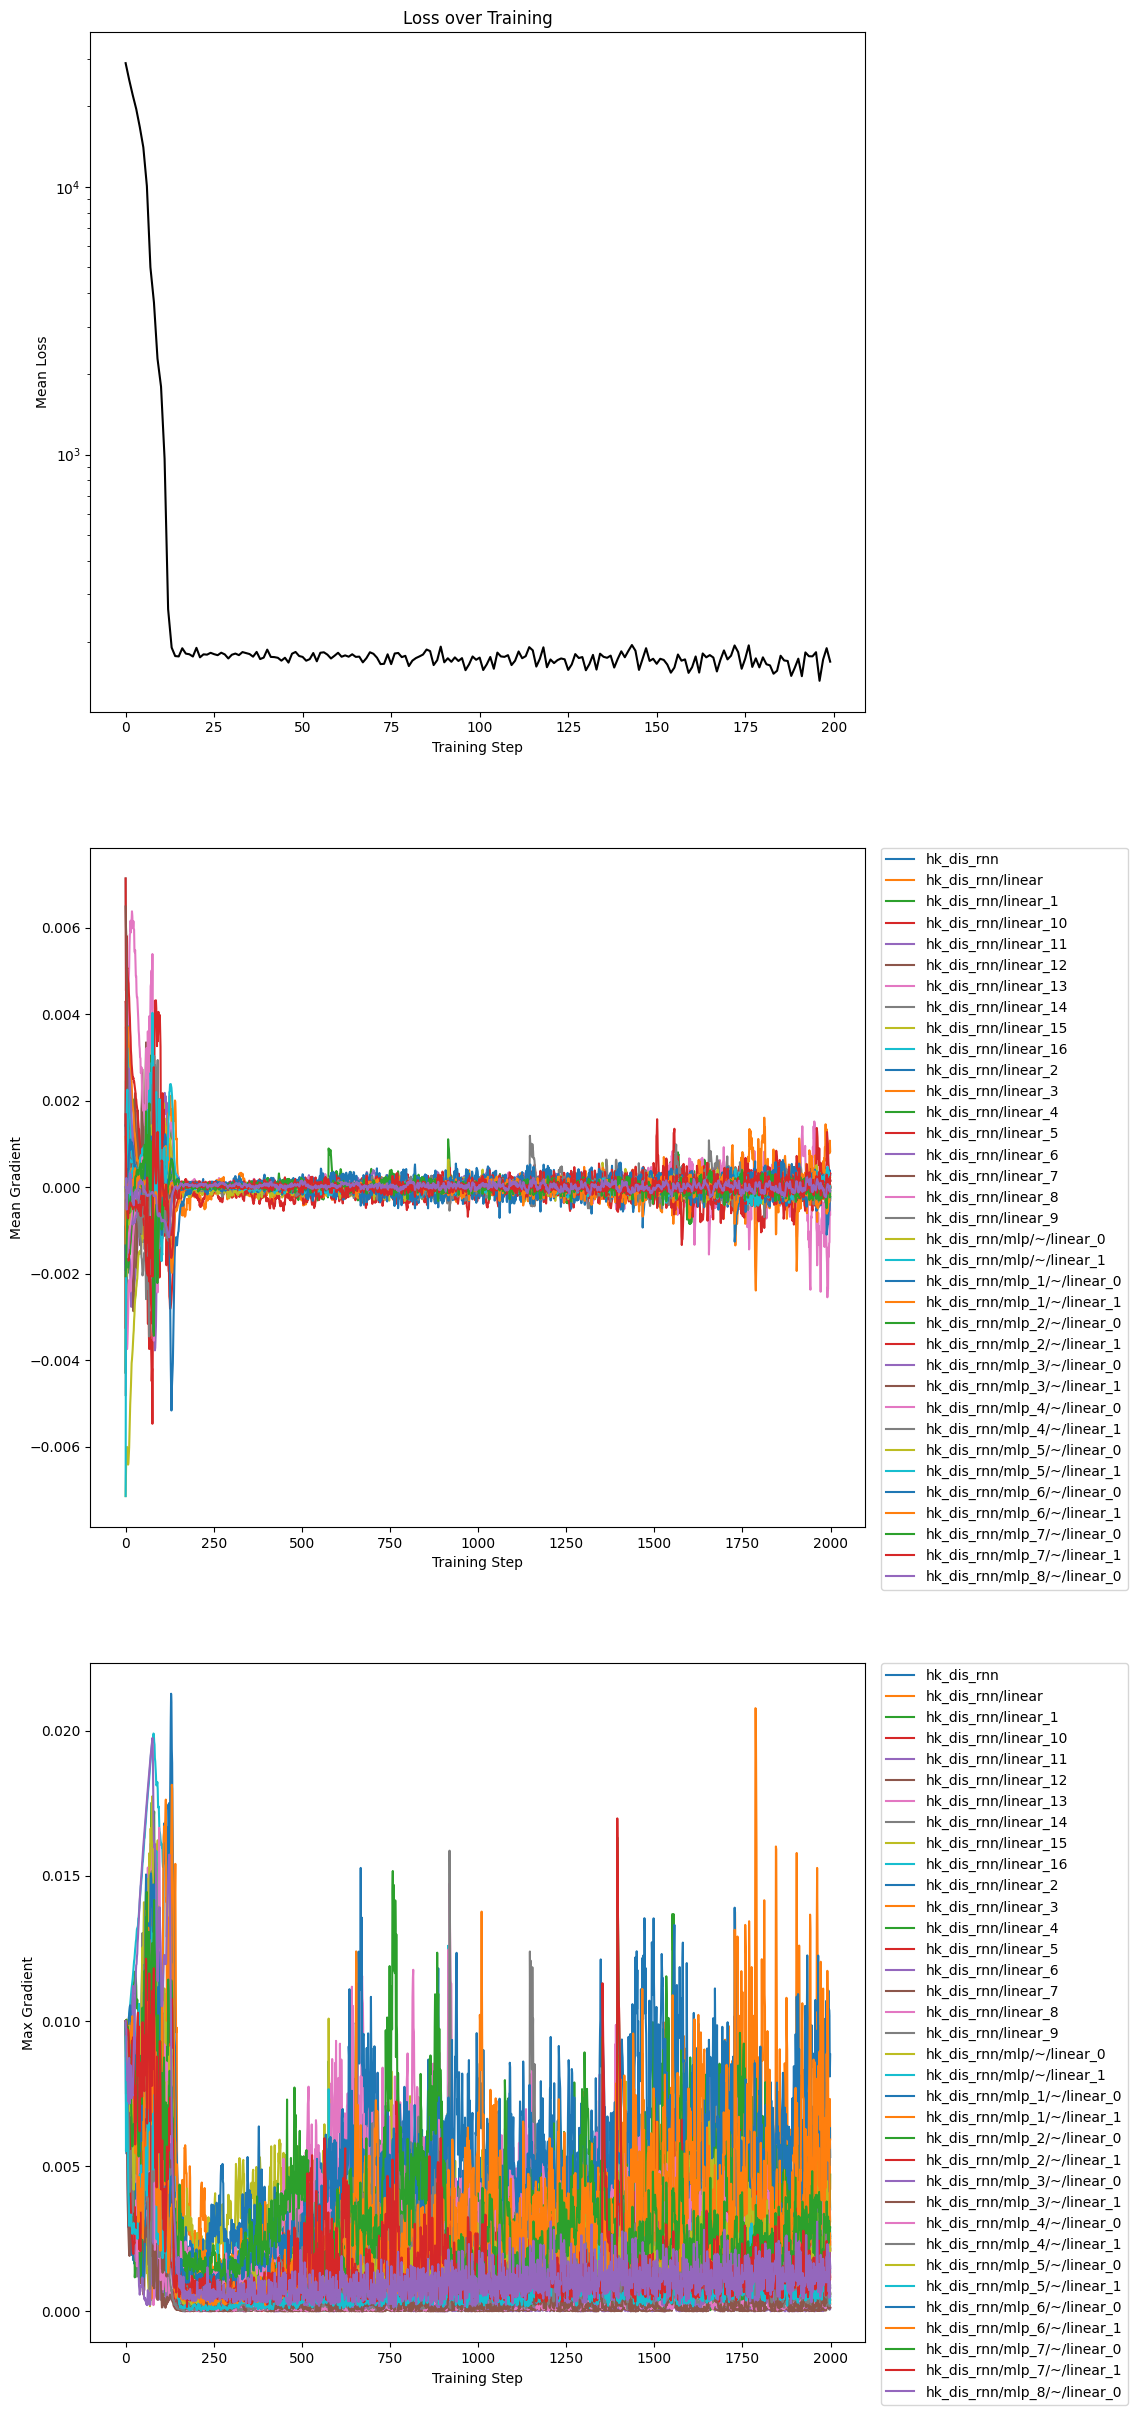

In [40]:
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=None
)

In [41]:
# # Now fit more steps with a penalty, to encourage it to find a simple solution
# n_steps = 3000  #@param
# information_penalty = 1e-3 #@param

# disrnn_params, opt_state, losses = rnn_utils.train_model(
#     model_fun = make_disrnn,
#     dataset = train,
#     optimizer = optimizer, # why were we saving the optimizer if we don't use it then?
#     loss_fun = 'penalized_categorical',
#     params=disrnn_params,
#     opt_state=opt_state,
#     penalty_scale=information_penalty,
#     n_steps=n_steps,
#     truncate_seq_length=200,
# )

Visualize model latents

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: title={'center': 'Latent Bottlenecks'}, ylabel='Latent #'>,
        <Axes: title={'center': 'Update MLP Bottlenecks'}, ylabel='Latent #'>],
       dtype=object))

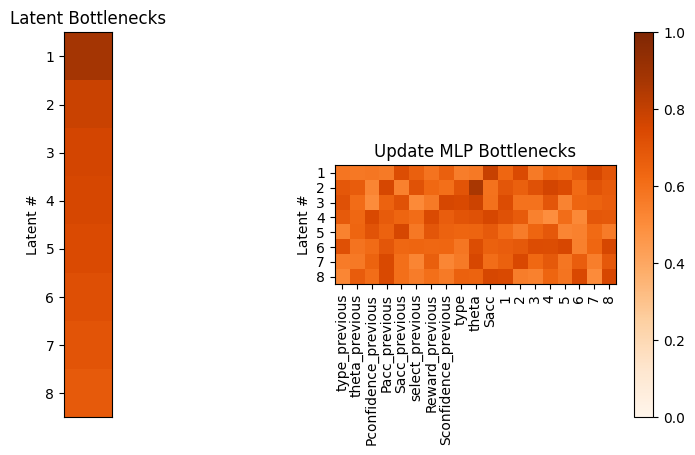

In [42]:
# Visualize bottleneck latents + learned update.
disrnn.plot_bottlenecks(disrnn_params, obs_names=features)
#disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)


# Calculate Normalized likelihoods

In [43]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood, training_output = subject_data.compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood, test_output = subject_data.compute_log_likelihood(
    test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 49.9%
Held-Out Dataset
Normalized Likelihood: 52.7%


## Plot the choices made by the model and the actual choices.

In [44]:
xs, actual_choices = next(train) # performance for the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

Plot the model predictions

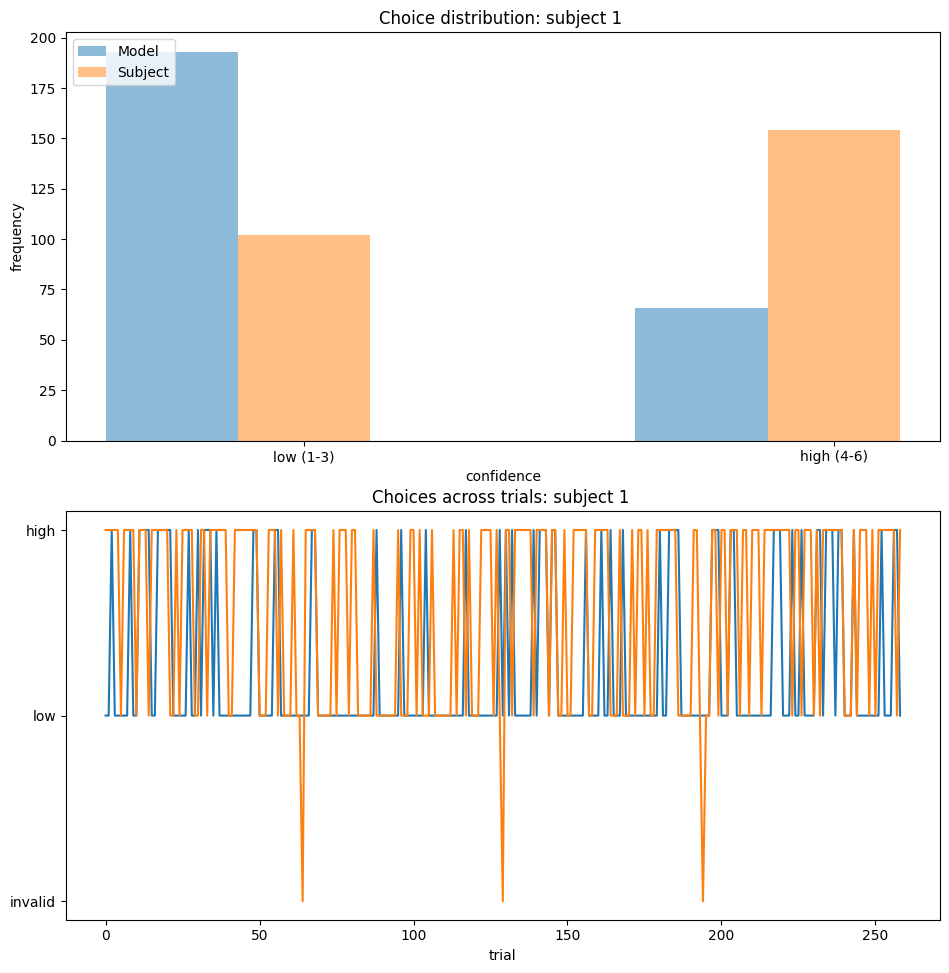

In [45]:
for i in range(model_outputs.shape[1]):

    model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
    model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))

    subject_choice = actual_choices[:, i]
    subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
    
    # Plot the distribution of choices for each subject
    labels = ("low (1-3)", "high (4-6)")
    all_choices = {'Model': model_counts, 'Subject': subject_counts}
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    #fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig, ax = plt.subplots(2, 1, figsize = (10, 10))
    fig.tight_layout(pad=3.0)

    for identity, count in all_choices.items():
        offset = width * multiplier
        rects = ax[0].bar(x + offset, count, width, alpha=0.5, label=identity)
        multiplier += 1

    ax[0].set_ylabel('frequency')
    ax[0].set_xlabel('confidence')
    ax[0].set_title('Choice distribution: subject {subject} '.format(subject=i+1))
    ax[0].set_xticks(x + width, labels)
    ax[0].legend(loc='upper left')
    
    # Plot the choices across all trials
    ax[1].plot(model_choice, label='Model')
    ax[1].plot(subject_choice, label='Subject')
    
    ax[1].set_xlabel('trial')
    ax[1].set_yticks([-1,0,1], labels=['invalid', 'low', 'high'])
    ax[1].set_title('Choices across trials: subject {subject} '.format(subject=i+1))

    plt.show()